In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
customer_train_df = pd.read_csv("customer_churn_dataset-training-master.csv")

# Renaming columns
customer_train_df.columns = [col.lower().replace(' ', '_') for col in customer_train_df.columns]

In [4]:
# Eliminating the column "CustomerID", since it will not bring any value to the analysis
customer_train_df.drop(columns=['customerid'], axis=1, inplace=True)

#Checking for NaN values
customer_train_df.isnull().sum()

#Eliminating the NaN values
customer_train_df.dropna(inplace=True)

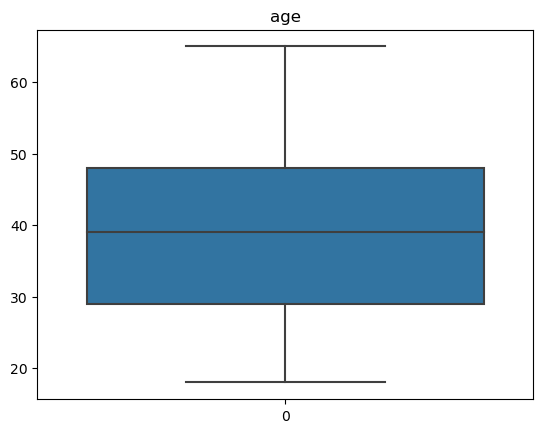

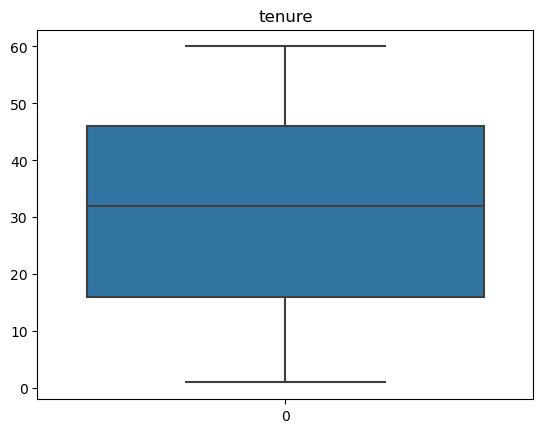

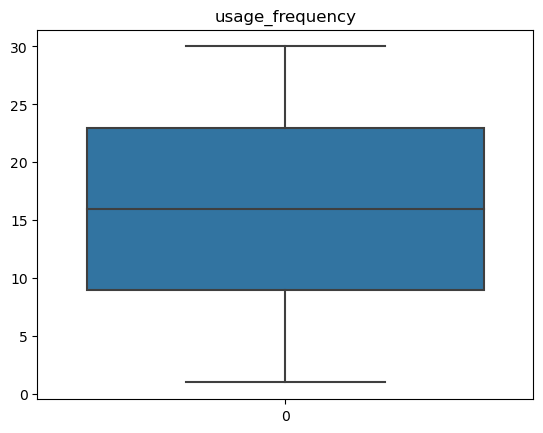

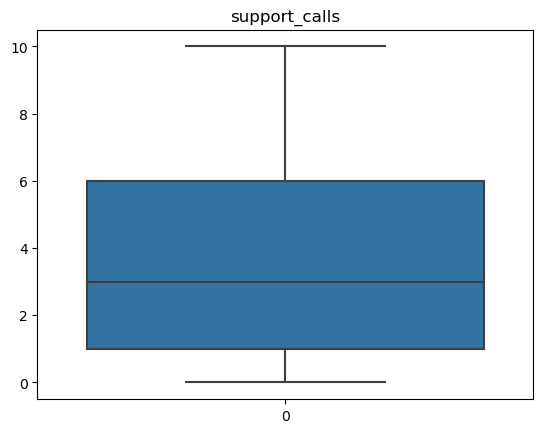

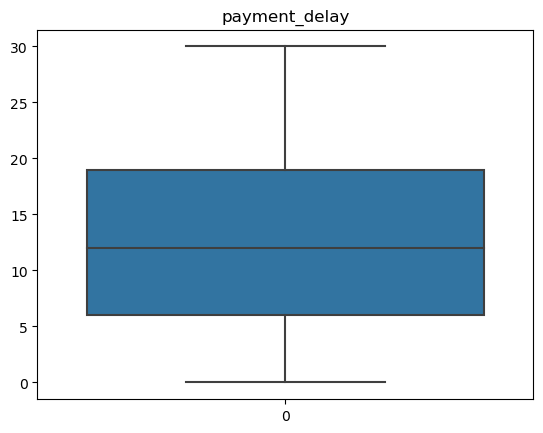

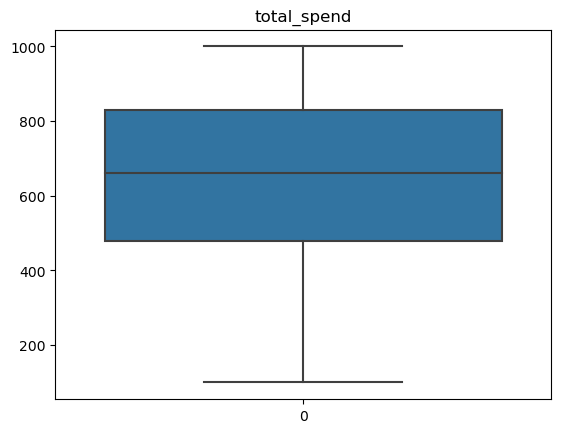

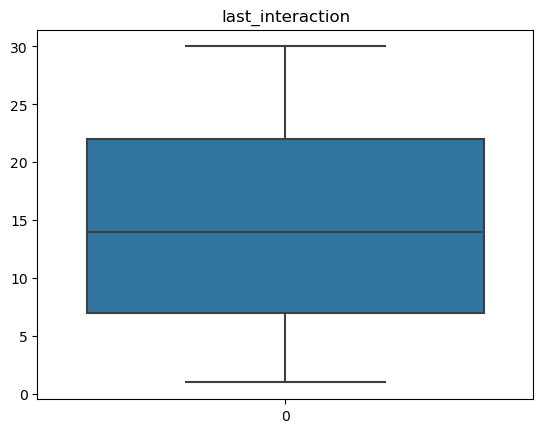

In [5]:
# Now we will analyze the distribution of the numerical values
num_cols_customer_train_df = customer_train_df[['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction']]
for col in num_cols_customer_train_df.columns:
    sns.boxplot(data=num_cols_customer_train_df[col])
    plt.title(f'{col}')
    plt.show()

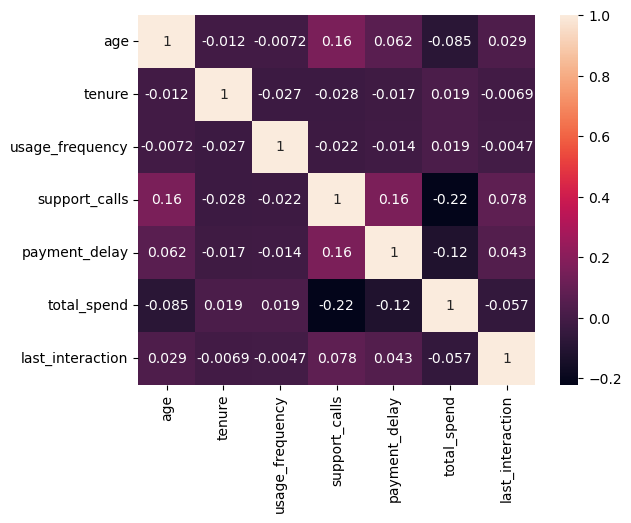

In [6]:
# There seems to be no outliers regarding the numerical values. Now we will check for multicollinearity

sns.heatmap(num_cols_customer_train_df.corr(), annot=True)
plt.show()

# Looking at the heatmap, we can use the features as they currently are because there is little correlation between the features

In [7]:
# Now we will apply one hot encoding for the categorical columns
dummy_df = pd.get_dummies(customer_train_df[['gender', 'subscription_type', 'contract_length']], drop_first=True)

In [8]:
# Joining the dummies with the original dataframe and dropping the categorical columns
df_joined = customer_train_df.join(dummy_df)
df_joined.drop(columns=['gender', 'subscription_type','contract_length'], inplace=True)

In [9]:
# Rearranging the columns
df_joined = df_joined[['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction', 'gender_Male', 'subscription_type_Premium', 'subscription_type_Standard', 'contract_length_Monthly', 'contract_length_Quarterly','churn']]

# Selecting numerical columns to normalize
columns_to_normalize = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction']

In [10]:
# Normalizing the dataset to avoid feature dominance and keep the numerical features on the same scale
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

for col in columns_to_normalize:
    df_joined[col]=scaler.fit_transform(df_joined[col].values.reshape(-1,1))


In [11]:
# Checking if the dataset is balanced
churn_count = df_joined['churn'].value_counts()


1.0    249999
0.0    190833
Name: churn, dtype: int64

In [12]:
# Data is unbalanced, SMOTE method will be used to balance the dataset
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

oversample=SMOTEENN(random_state=332)

X = df_joined.drop('churn', axis=1)
y = df_joined['churn']

X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=332)



In [13]:
# Training a random forest classifier for this dataset
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=40, random_state=332)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40, random_state=332)

In [14]:
# Reviewing the accuracy of the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9999354741574


<Axes: >

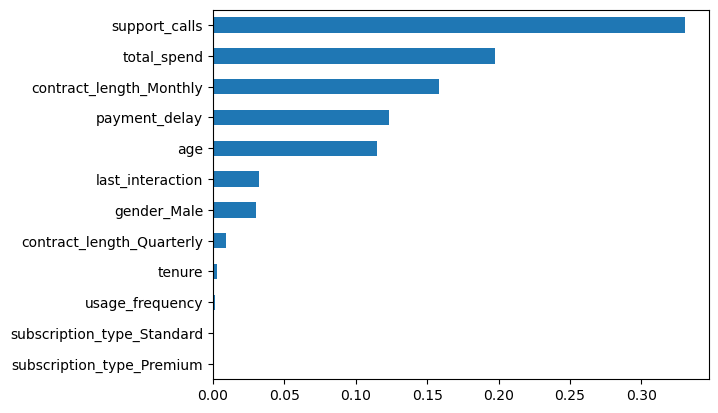

In [16]:
featureimp = pd.Series(model.feature_importances_ , index = X_train.columns).sort_values(ascending = True)
featureimp.plot(kind = 'barh')

As it can be seen here, only a handful of features matter for the prediction. The driving forces for a prediction are support calls, total spend and contract length. Reducing the number of these variables reduces the probability of a customer churning.